In [37]:
# importing all relevant libraries

import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.models import load_model

In [38]:
# obtaining path for images for training

data_dir = 'Detect_solar_dust/'

os.listdir(data_dir) # checking folders inside path

['Clean', 'Dusty']

In [39]:
image_exts = ['jpeg','jpg', 'bmp', 'png'] # compatible file extensions


# loop to remove uncompatible images (incorrect file extension)

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image) # obtaining path of an individual image
        try: # exception handling to not interrupt process
            img = cv2.imread(image_path) # makes image reabable
            tip = imghdr.what(image_path) # obtaining file extension
            if tip not in image_exts:
                os.remove(image_path) # removes image if it has uncompatible file extension
        except Exception as e:
            print(f'Issue with image {image_path}')
            os.remove(image_path)

## Load Data

In [40]:
data = tf.keras.utils.image_dataset_from_directory('Detect_solar_dust/') # finding the data

Found 2220 files belonging to 2 classes.


In [41]:
data_iterator = data.as_numpy_iterator() # converts into numpy iterator

batch = data_iterator.next() # grabbing a batch of images

len(batch) # 2 parts, images and labels, first is images, second is labels

2

In [42]:
# images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [43]:
# labels (target variable)
batch[1]

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

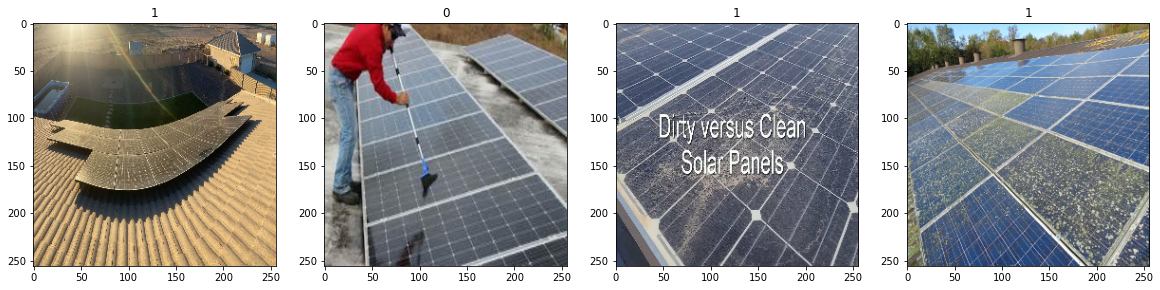

In [44]:
# plotting images in the batch to check labels

fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# 1 for dirty, 0 for clean

## Preprocessing Data

In [45]:
data = data.map(lambda x,y: (x/255, y)) # x is image, y is target variable (labels)
# gets data (x) and scales it to ensure x values are between 0 and 1

scaled_iterator = data.as_numpy_iterator() # uses numpy iterator to skip through a numpy array

batch = scaled_iterator.next() # obtaining a new batch that has been scaled

## Splitting Data

In [46]:
# specifying magnitude of data split

train_size = int(len(data)*0.8) # 80 percent for training
val_size = int(len(data)*0.1) # 10 percent for validating
test_size = int(len(data)*0.1) # 10 percent for testing

train_size, val_size, test_size # checking image split

(56, 7, 7)

In [47]:
# taking train, test, validation sets from batch according to sizes specified above

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building the Network 

In [48]:
model = Sequential()

# adding convolution layer with relu activation and L2 regularisation of 0.6
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.6)))

# adding max pool to obtain maximum value in a patch to avoid overfitting
model.add(MaxPooling2D())

# reducing the dimension of input to a 1D numpy array
model.add(Flatten())

# adding a dense layer to obtain binary output using sigmoid activation
model.add(Dense(1, activation='sigmoid')) # 1 is for 1 dimension


In [49]:
# invoking adam algorithm to optimise model, loss is binary cross entropy because output is binary
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# shows the structure of the CNN model
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 258064)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 258065    
                                                                 
Total params: 258,513
Trainable params: 258,513
Non-trainable params: 0
_________________________________________________________________


In [50]:
# creating a log directory to save model
logdir = 'logs'

# making a tensor board
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# epoch is one run over training set, thus 20 runs
# hist is history

Epoch 1/20
56/56 [==============================] - 38s 635ms/step - loss: 4.1416 - accuracy: 0.6356 - val_loss: 2.6931 - val_accuracy: 0.6786
Epoch 2/20
56/56 [==============================] - 37s 631ms/step - loss: 2.2696 - accuracy: 0.7450 - val_loss: 2.1133 - val_accuracy: 0.6295
Epoch 3/20
56/56 [==============================] - 37s 638ms/step - loss: 1.6978 - accuracy: 0.8119 - val_loss: 1.5152 - val_accuracy: 0.8348
Epoch 4/20
56/56 [==============================] - 39s 667ms/step - loss: 1.2746 - accuracy: 0.8823 - val_loss: 1.2006 - val_accuracy: 0.8393
Epoch 5/20
56/56 [==============================] - 39s 674ms/step - loss: 0.9713 - accuracy: 0.9169 - val_loss: 0.9841 - val_accuracy: 0.8304
Epoch 6/20
56/56 [==============================] - 37s 624ms/step - loss: 0.7658 - accuracy: 0.9442 - val_loss: 0.8457 - val_accuracy: 0.8661
Epoch 7/20
56/56 [==============================] - 37s 633ms/step - loss: 0.6078 - accuracy: 0.9548 - val_loss: 0.7711 - val_accuracy: 0.8438

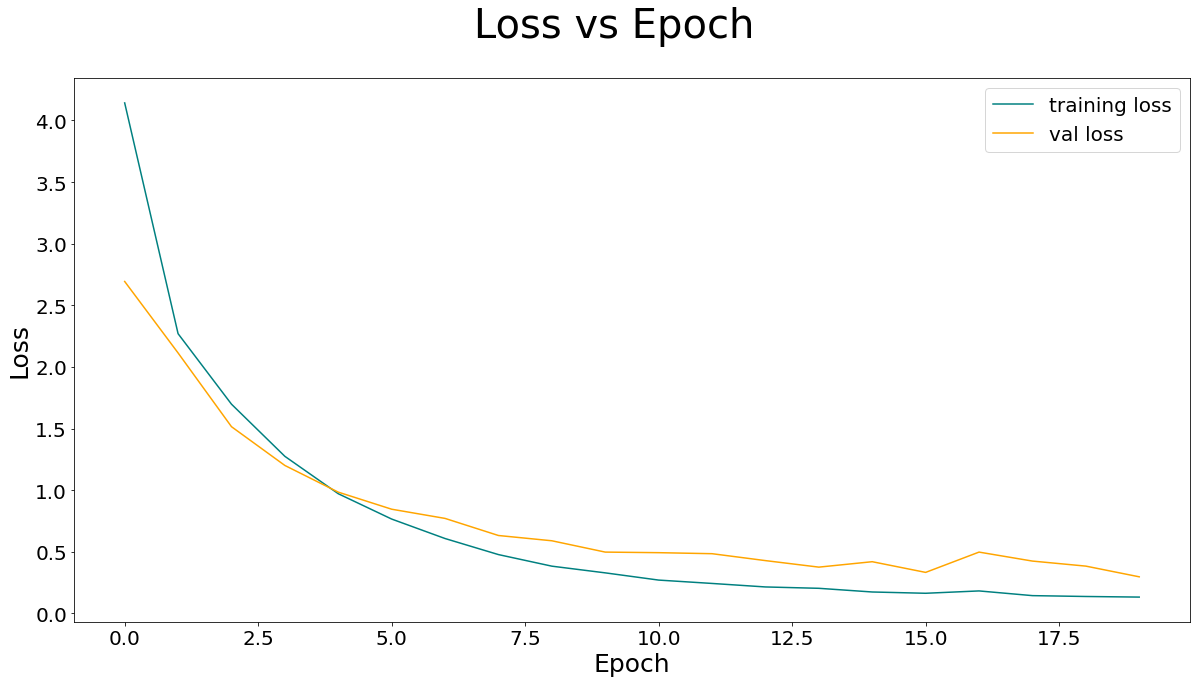

In [54]:
# plotting a line graph with the loss of the training and validation set vs epoch

fig = plt.figure(figsize=(20,10))
plt.plot(hist.history['loss'], color='teal', label='training loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
fig.suptitle('Loss vs Epoch', fontsize=40)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Loss', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('loss_vs_epoch.jpg') # saving image to path

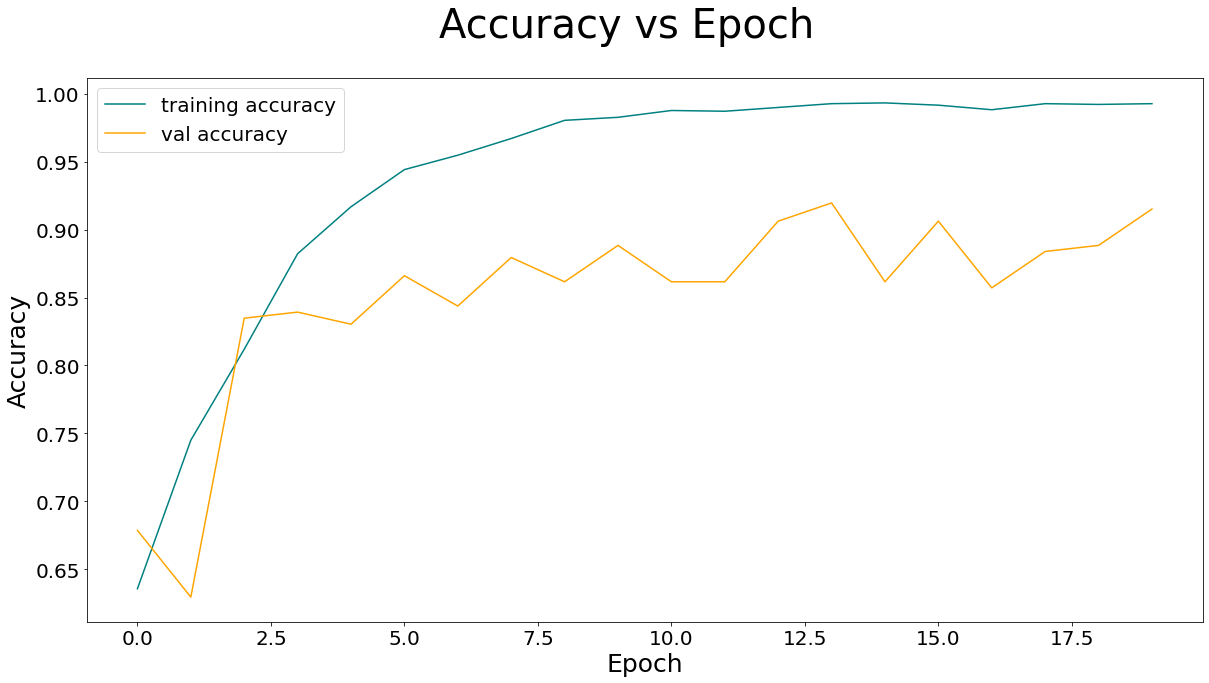

In [55]:
# plotting graph of accuracy of training and validation sets vs epoch

fig = plt.figure(figsize=(20,10))
plt.plot(hist.history['accuracy'], color='teal', label='training accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy vs Epoch', fontsize=40)
plt.legend(loc="upper left", fontsize=20)

plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('accuracy_vs_epoch.jpg')

In [56]:
# creating a class instance to obtain precision, recall and accuracy of model
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# looping over images in the test batch to compare the prediction with the test data
for batch in test.as_numpy_iterator(): 
    X, y = batch # obtaining predictor variable (image) and label (1 or 0)
    yhat = model.predict(X) # making prediction based on test batch

    # updating valuation metric values using y_actual and y_predicted
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result()) # displaying results of valuation metrics of model

1/1 [==============================] - 0s 76ms/step
tf.Tensor(0.8309859, shape=(), dtype=float32) tf.Tensor(0.75641024, shape=(), dtype=float32) tf.Tensor(0.8480392, shape=(), dtype=float32)


## Testing the Model 

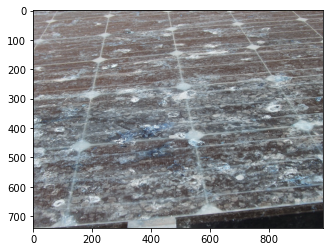

In [93]:
# obtaining image of from dusty folder to visually test model

img = cv2.imread('Detect_solar_dust/Dusty/Imgdirty_127_1.jpg')
plt.imshow(img)
plt.show()

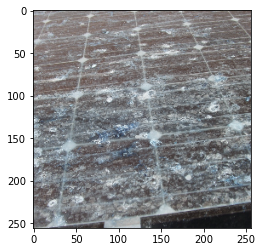

In [94]:
# resizing image as preparation for using it in the model

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [95]:
# making prediction from image

yhat = model.predict(np.expand_dims(resize/255, 0)) # expand dim adds another dimension in order for prediction to understand
yhat

1/1 [==============================] - 0s 18ms/step


array([[0.98139054]], dtype=float32)

In [96]:
# determining if it is clean or dusty using a 50 percent confidence level

if yhat > 0.5: 
    print(f'Predicted class is Dusty')
else:
    print(f'Predicted class is Clean')

Predicted class is Dusty


## Save the Model

In [61]:
model.save(os.path.join('models', 'dusty_clean_model_l2_06.h5')) # exporting model

In [62]:
# reloading model

new_model = load_model(os.path.join('models', 'dusty_clean_model.h5'))

In [63]:
yhat_new = model.predict((np.expand_dims(resize/255, 0)))
# you can use a previous model without running the algorithm again

1/1 [==============================] - 0s 23ms/step


In [64]:
yhat_new

array([[0.9429367]], dtype=float32)

## Exporting Data into Excel

In [65]:
# loading model accuracy results into a dataframe

df_model_accuracy = pd.DataFrame(hist.history['val_accuracy'], columns=['val_accuracy'])

df_model_accuracy['train_accuracy'] = hist.history['accuracy'] 

df_model_accuracy['epoch'] = range(1,21)

df_model_accuracy

val_accuracy  train_accuracy  epoch
0       0.678571        0.635603      1
1       0.629464        0.744978      2
2       0.834821        0.811942      3
3       0.839286        0.882254      4
4       0.830357        0.916853      5
5       0.866071        0.944196      6
6       0.843750        0.954799      7
7       0.879464        0.967076      8
8       0.861607        0.980469      9
9       0.888393        0.982701     10
10      0.861607        0.987723     11
11      0.861607        0.987165     12
12      0.906250        0.989955     13
13      0.919643        0.992746     14
14      0.861607        0.993304     15
15      0.906250        0.991629     16
16      0.857143        0.988281     17
17      0.883929        0.992746     18
18      0.888393        0.992188     19
19      0.915179        0.992746     20

In [66]:
# loading model loss results into a dataframe

df_model_loss = pd.DataFrame(hist.history['val_loss'], columns=['val_loss'])

df_model_loss['train_loss'] = hist.history['loss']

df_model_loss['epoch'] = range(1,21)

df_model_loss

val_loss  train_loss  epoch
0   2.693142    4.141618      1
1   2.113297    2.269553      2
2   1.515192    1.697821      3
3   1.200577    1.274640      4
4   0.984144    0.971295      5
5   0.845689    0.765844      6
6   0.771051    0.607840      7
7   0.632404    0.477568      8
8   0.589641    0.383671      9
9   0.497799    0.329339     10
10  0.493108    0.270766     11
11  0.484821    0.243515     12
12  0.428775    0.215078     13
13  0.375862    0.204059     14
14  0.419825    0.174197     15
15  0.333155    0.163772     16
16  0.497797    0.182793     17
17  0.424968    0.144650     18
18  0.384090    0.137720     19
19  0.297278    0.132807     20

In [67]:
# exporting dataframes into an excel file for PowerBI visualisations

df_model_accuracy.to_excel('model_accuracy.xlsx')

df_model_loss.to_excel('model_loss.xlsx')